## Plant Seedlings Competition

https://www.kaggle.com/c/plant-seedlings-classification/

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.imports import *

In [3]:
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

In [4]:
PATH = "./data/plant-seedlings/"

In [11]:
sz = 300

## Exploration

In [6]:
!ls {PATH}

sample_submission.csv  test  train  valid


In [7]:
!ls {PATH}valid

Black-grass  Common Chickweed  Loose Silky-bent   Shepherds Purse
Charlock     Common wheat      Maize		  Small-flowered Cranesbill
Cleavers     Fat Hen	       Scentless Mayweed  Sugar beet


In [8]:
files = !ls {PATH}valid/Black-grass | head
files

['05eedce4d.png',
 '082314602.png',
 '0ace21089.png',
 '0be707615.png',
 '0c67c3fc3.png',
 '0d4f74f4a.png',
 '0dad57e7f.png',
 '0fe440ed5.png',
 '1276dffba.png',
 '14719a83e.png']

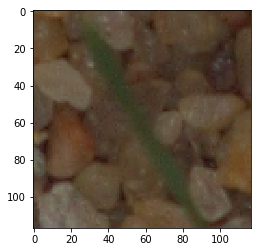

In [9]:
img = plt.imread(f'{PATH}valid/Black-grass/{files[0]}')
plt.imshow(img);

Here is how the raw data looks like

In [10]:
img.shape

(117, 117, 3)

In [11]:
img[:4,:4]

array([[[ 0.42353,  0.32941,  0.2    ],
        [ 0.43922,  0.34902,  0.21961],
        [ 0.43137,  0.3451 ,  0.21176],
        [ 0.43529,  0.34902,  0.21569]],

       [[ 0.39608,  0.30196,  0.16863],
        [ 0.4    ,  0.30196,  0.16863],
        [ 0.40784,  0.3098 ,  0.17647],
        [ 0.41176,  0.31373,  0.18431]],

       [[ 0.36863,  0.26667,  0.12941],
        [ 0.38039,  0.27451,  0.14902],
        [ 0.38431,  0.27843,  0.14902],
        [ 0.38824,  0.27843,  0.1451 ]],

       [[ 0.37647,  0.27451,  0.15294],
        [ 0.37647,  0.26667,  0.1451 ],
        [ 0.38039,  0.26667,  0.15294],
        [ 0.38039,  0.26275,  0.14902]]], dtype=float32)

## Modelling

In [12]:
# Uncomment the below if you need to reset your precomputed activations
!rm -rf {PATH}tmp

In [13]:
arch = resnet50
data = ImageClassifierData.from_paths(PATH, tfms=tfms_from_model(arch, sz), test_name='test')
learn = ConvLearner.pretrained(arch, data, precompute=True)
learn.fit(0.1, 3)

100%|██████████| 13/13 [00:03<00:00,  3.42it/s]


HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

[ 0.       1.22489  0.55208  0.80236]                     
[ 1.       0.8148   0.55609  0.8284 ]                      
[ 2.       0.61824  0.3724   0.88076]                      



## Analyzing results: looking at pictures

As well as looking at the overall metrics, it's also a good idea to look at examples of each of:
1. A few correct labels at random
2. A few incorrect labels at random
3. The most correct labels of each class (ie those with highest probability that are correct)
4. The most incorrect labels of each class (ie those with highest probability that are incorrect)
5. The most uncertain labels (ie those with probability closest to 0.5).

In [ ]:
# This is the label for a val data
data.val_y

In [ ]:
data.classes

In [ ]:
# this gives prediction for validation set. Predictions are in log scale
log_preds = learn.predict()
log_preds.shape

In [ ]:
log_preds[:10]

In [ ]:
preds = np.argmax(log_preds, axis=1)  # from log probabilities to 0 or 1
probs = np.exp(log_preds[:,1])        # pr(dog)

In [ ]:
def rand_by_mask(mask): return np.random.choice(np.where(mask)[0], 4, replace=False)
def rand_by_correct(is_correct): return rand_by_mask((preds == data.val_y)==is_correct)

In [ ]:
def plot_val_with_title(idxs, title):
    imgs = np.stack([data.val_ds[x][0] for x in idxs])
    title_probs = [probs[x] for x in idxs]
    print(title)
    return plots(data.val_ds.denorm(imgs), rows=1, titles=title_probs)

In [ ]:
def plots(ims, figsize=(12,6), rows=1, titles=None):
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims)//rows, i+1)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i])

In [ ]:
def load_img_id(ds, idx): return np.array(PIL.Image.open(PATH+ds.fnames[idx]))

def plot_val_with_title(idxs, title):
    imgs = [load_img_id(data.val_ds,x) for x in idxs]
    title_probs = [probs[x] for x in idxs]
    print(title)
    return plots(imgs, rows=1, titles=title_probs, figsize=(16,8))

In [ ]:
# 1. A few correct labels at random
plot_val_with_title(rand_by_correct(True), "Correctly classified")

In [ ]:
# 2. A few incorrect labels at random
plot_val_with_title(rand_by_correct(False), "Incorrectly classified")

In [ ]:
def most_by_mask(mask, mult):
    idxs = np.where(mask)[0]
    return idxs[np.argsort(mult * probs[idxs])[:4]]

def most_by_correct(y, is_correct): 
    mult = -1 if (y==1)==is_correct else 1
    return most_by_mask((preds == data.val_y)==is_correct & (data.val_y == y), mult)

In [ ]:
plot_val_with_title(most_by_correct(0, True), "Most correct Black-grass")

In [ ]:
plot_val_with_title(most_by_correct(1, True), "Most correct Charlock")

In [ ]:
plot_val_with_title(most_by_correct(0, False), "Most incorrect Black-grass")

In [ ]:
plot_val_with_title(most_by_correct(1, False), "Most incorrect Charlock")

In [ ]:
most_uncertain = np.argsort(np.abs(probs -0.5))[:4]
plot_val_with_title(most_uncertain, "Most uncertain predictions")

## Choosing a learning rate

The *learning rate* determines how quickly or how slowly you want to update the *weights* (or *parameters*). Learning rate is one of the most difficult parameters to set, because it significantly affect model performance.

The method `learn.lr_find()` helps you find an optimal learning rate. It uses the technique developed in the 2015 paper [Cyclical Learning Rates for Training Neural Networks](http://arxiv.org/abs/1506.01186), where we simply keep increasing the learning rate from a very small value, until the loss starts decreasing. We can plot the learning rate across batches to see what this looks like.

We first create a new learner, since we want to know how to set the learning rate for a new (untrained) model.

In [ ]:
learn = ConvLearner.pretrained(arch, data, precompute=True)

In [ ]:
lrf=learn.lr_find()

Our `learn` object contains an attribute `sched` that contains our learning rate scheduler, and has some convenient plotting functionality including this one:

In [ ]:
learn.sched.plot_lr()

Note that in the previous plot *iteration* is one iteration (or *minibatch*) of SGD. In one epoch there are 
(num_train_samples/num_iterations) of SGD.

We can see the plot of loss versus learning rate to see where our loss stops decreasing:

In [ ]:
learn.sched.plot()

The loss is still clearly improving at lr=1e-2 (0.01), so that's what we use. Note that the optimal learning rate can change as we training the model, so you may want to re-run this function from time to time.

## Improving our model

### Data augmentation

In [14]:
tfms = tfms_from_model(arch, sz, aug_tfms=transforms_side_on, max_zoom=1.1)

In [15]:
def get_augs():
    data = ImageClassifierData.from_paths(PATH, bs=2, tfms=tfms, test_name='test', num_workers=1)
    x,_ = next(iter(data.aug_dl))
    return data.trn_ds.denorm(x)[1]

In [16]:
ims = np.stack([get_augs() for i in range(6)])

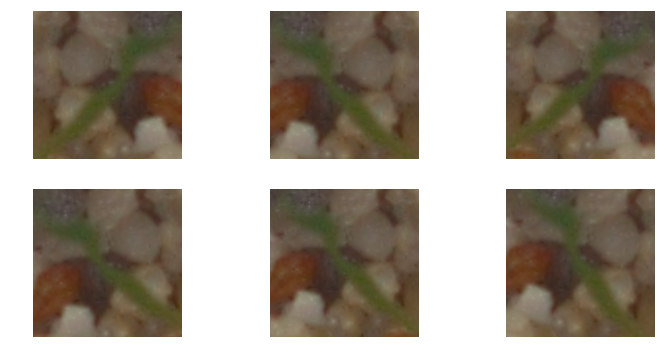

In [17]:
plots(ims, rows=2)

In [18]:
data = ImageClassifierData.from_paths(PATH, tfms=tfms, test_name='test')
learn = ConvLearner.pretrained(arch, data, precompute=True)

In [19]:
learn.fit(1e-1, 1)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

[ 0.       1.24448  0.73066  0.79276]                     



In [20]:
learn.precompute=False

In [21]:
learn.fit(1e-1, 3, cycle_len=1)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

[ 0.       0.68537  0.31538  0.89556]                      
[ 1.       0.53263  0.26745  0.89638]                      
[ 2.       0.49594  0.2605   0.90296]                      



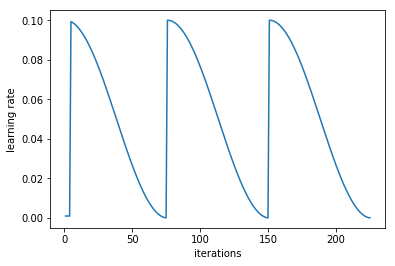

In [22]:
learn.sched.plot_lr()

In [23]:
learn.save('224_lastlayer')

In [24]:
learn.load('224_lastlayer')

### Fine-tuning and Differential Learning Rate Annealing

In [25]:
learn.unfreeze()

In [26]:
lr = np.array([1e-4,1e-3,1e-1])

In [50]:
learn.fit(lr, 5, cycle_len=1, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=31), HTML(value='')))

[ 0.       0.00637  0.00118  1.     ]                        
[ 1.       0.00542  0.00136  1.     ]                        
[ 2.       0.00851  0.00315  0.99835]                        
[ 3.       0.00753  0.00264  0.99918]                        
  4%|▍         | 3/75 [00:03<01:16,  1.07s/it, loss=0.00744]

KeyboardInterrupt: 

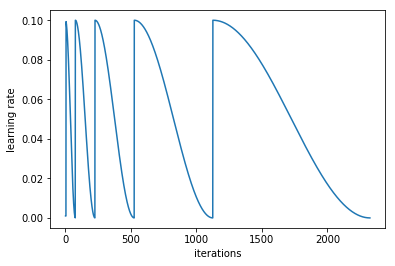

In [41]:
learn.sched.plot_lr()

In [42]:
learn.save('224_all')

In [43]:
learn.load('224_all')

## Evaluation

In [44]:
val_log_preds, val_y = learn.TTA()
accuracy(val_log_preds, val_y)

1.0

In [45]:
test_log_preds, test_y = learn.TTA(is_test=True)

In [46]:
test_labels = []
test_preds = np.argmax(test_log_preds, axis=1)

for i in range(test_preds.size):
    test_labels.append(data.classes[test_preds[i]])

In [47]:
outp = pd.DataFrame({'file': [f[5:] for f in data.test_dl.dataset.fnames],
                     'species': [''.join(l) for l in test_labels]})
outp.head()

,file,species
0,12625488b.png,Fat Hen
1,c832e4302.png,Fat Hen
2,e82017baa.png,Loose Silky-bent
3,c10ccbd82.png,Scentless Mayweed
4,8b27bfd2b.png,Small-flowered Cranesbill


In [48]:
outp.to_csv(PATH + 'tmp/subm.csv.gz', compression='gzip', index=None)

In [49]:
from IPython.display import FileLink
FileLink(PATH + 'tmp/subm.csv.gz')

/home/ubuntu/nbs/data/plant-seedlings/tmp/subm.csv.gz